In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit import transpile, assemble, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from sympy import Matrix
import matplotlib.pyplot as plt
from qiskit.circuit.instruction import Instruction
from qiskit.circuit.quantumcircuitdata import QuantumCircuitData, CircuitInstruction
from qiskit.circuit.classicalregister import ClassicalRegister, Clbit
from qiskit.circuit.quantumregister import QuantumRegister, Qubit
from qiskit.circuit.library.standard_gates.h import *
import qiskit
import numpy as np
from typing import (
    Union,
    Optional,
    List,
    Dict,
    Tuple,
    Type,
    TypeVar,
    Sequence,
    Callable,
    Mapping,
    Set,
    Iterable,
)
import warnings
warnings.filterwarnings("ignore")

C:\Users\anura\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


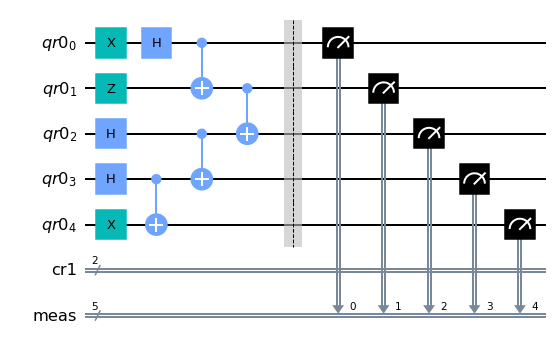

In [2]:
qc = QuantumCircuit(QuantumRegister(5, 'qr0'), ClassicalRegister(2, 'cr1'))
qc.x(0)
qc.h(0)
qc.z(1)
qc.cx(0,1)
qc.x(4)
qc.h(3)
# qc.barrier()
qc.h(2)
qc.cx(3,4)
qc.cx(2,3)
qc.cx(1,2)
qc.measure_all()
qc.draw(output='mpl')

In [3]:
qc.depth()

5

In [4]:
def layer_decomp(
        circ,
        filter_function: Optional[callable] = lambda x: not getattr(
            x.operation, "_directive", False
        ),
    ) -> int: 
    # Assign each bit in the circuit a unique integer
        # to index into op_stack.
    bit_indices = {bit: idx for idx, bit in enumerate(circ.qubits + circ.clbits)}

    # If no bits, return 0
    if not bit_indices:
        return 0

    # A list that holds the height of each qubit
    # and classical bit.
    op_stack = [0] * len(bit_indices)
    layers = []
    for instruction in qc.data:
            levels = []
            reg_ints = []
            considered = False
            for ind, reg in enumerate(instruction.qubits + instruction.clbits):
                # Add to the stacks of the qubits and
                # cbits used in the gate.
                reg_ints.append(bit_indices[reg])
                if filter_function(instruction):
                    levels.append(op_stack[reg_ints[ind]] + 1)
                    if len(layers) < (op_stack[reg_ints[ind]] + 1):
                        layers.append([])
                    if not considered:
                        layers[op_stack[reg_ints[ind]]].append(instruction)
                        considered = True
                else:
                    levels.append(op_stack[reg_ints[ind]])
            # Assuming here that there is no conditional
            # snapshots or barriers ever.
            if getattr(instruction.operation, "condition", None):
                # Controls operate over all bits of a classical register
                # or over a single bit
                if isinstance(instruction.operation.condition[0], Clbit):
                    condition_bits = [instruction.operation.condition[0]]
                else:
                    condition_bits = instruction.operation.condition[0]
                for cbit in condition_bits:
                    idx = bit_indices[cbit]
                    if idx not in reg_ints:
                        reg_ints.append(idx)
                        levels.append(op_stack[idx] + 1)
            max_level = max(levels)
            for ind in reg_ints:
                op_stack[ind] = max_level

    assert max(op_stack) == len(layers)
    
    return layers 
    

In [5]:
layers = layer_decomp(qc)
layers

[[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 0),), clbits=()),
  CircuitInstruction(operation=Instruction(name='z', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 1),), clbits=()),
  CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 4),), clbits=()),
  CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 3),), clbits=()),
  CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 2),), clbits=())],
 [CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 0),), clbits=()),
  CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, param

In [6]:
def layer_ops(layers):
    qc = QuantumCircuit(QuantumRegister(5, 'qr0'), ClassicalRegister(2, 'cr1'))
    all_ops = []
    for layer in layers:
        all_ops += layer
    print(all_ops)
    qc.data = all_ops

In [7]:
def layer_recomb(
    layers: Iterable[
        List],
    *,
    qubits: Iterable[Qubit] = (),
    clbits: Iterable[Clbit] = (),
    name: Optional[str] = None,
    global_phase = 0,
    metadata: Optional[dict] = None,
) -> "QuantumCircuit":
    """Construct a circuit from an iterable of list of CircuitInstructions.

    Args:
        instructions: The instructions to add to the circuit.
        qubits: Any qubits to add to the circuit. This argument can be used,
            for example, to enforce a particular ordering of qubits.
        clbits: Any classical bits to add to the circuit. This argument can be used,
            for example, to enforce a particular ordering of classical bits.
        name: The name of the circuit.
        global_phase: The global phase of the circuit in radians.
        metadata: Arbitrary key value metadata to associate with the circuit.

    Returns:
        The quantum circuit.
    """
    circuit = QuantumCircuit(name=name, global_phase=global_phase, metadata=metadata)
    added_qubits = set()
    added_clbits = set()
    if qubits:
        qubits = list(qubits)
        circuit.add_bits(qubits)
        added_qubits.update(qubits)
    if clbits:
        clbits = list(clbits)
        circuit.add_bits(clbits)
        added_clbits.update(clbits)
    for layer in layers:
        for instruction in layer:
#             print(instruction)
            if not isinstance(instruction, CircuitInstruction):
                instruction = CircuitInstruction(*instruction)
            qubits = [qubit for qubit in instruction.qubits if qubit not in added_qubits]
            clbits = [clbit for clbit in instruction.clbits if clbit not in added_clbits]
            circuit.add_bits(qubits)
            circuit.add_bits(clbits)
            added_qubits.update(qubits)
            added_clbits.update(clbits)
            circuit._append(instruction)
    return circuit

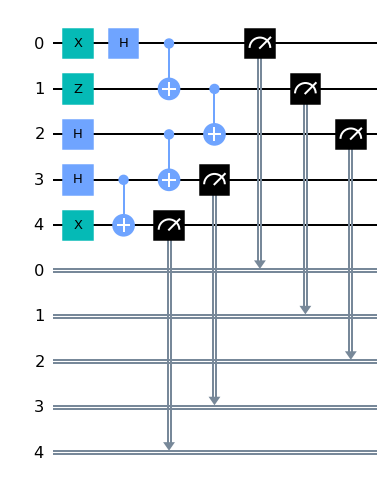

In [8]:
Qubit_list = [Qubit(QuantumRegister(5, 'qr0'), i) for i in range(5)]
Cbit_list = [Clbit(ClassicalRegister(5, 'hola'), i) for i in range(5)]
qc_recons = layer_recomb(layers, qubits=Qubit_list)
# print(qc_recons.data)
qc_recons.draw(output='mpl')

In [9]:
qc_recons.depth()

5

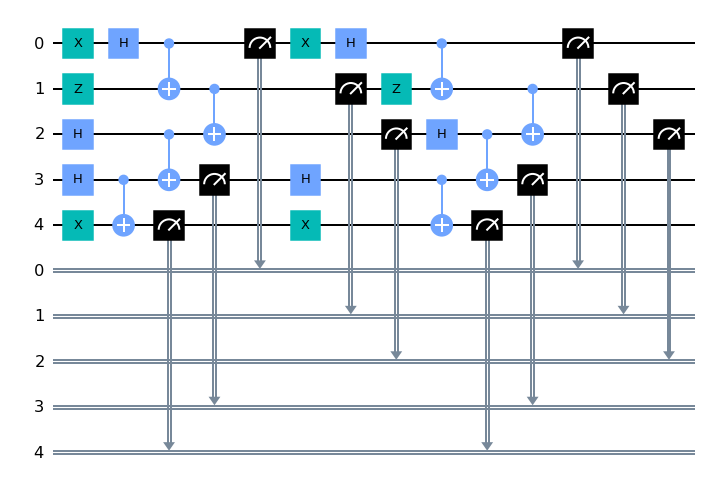

In [10]:
layers += layers
qc_recons = layer_recomb(layers, qubits=Qubit_list)
# print(qc_recons.data)
qc_recons.draw(output='mpl')

In [11]:
from circuit_remapper import *

circ_object = CircuitRemapper(qc,"hi")
layers_here = circ_object._circuit_to_layers()
layers_here

[[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 0),), clbits=()),
  CircuitInstruction(operation=Instruction(name='z', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 1),), clbits=()),
  CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 4),), clbits=()),
  CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 3),), clbits=()),
  CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 2),), clbits=())],
 [CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 0),), clbits=()),
  CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, param

In [12]:
layers_here += layers_here
circ_object._layer_to_circuit(layers_here)

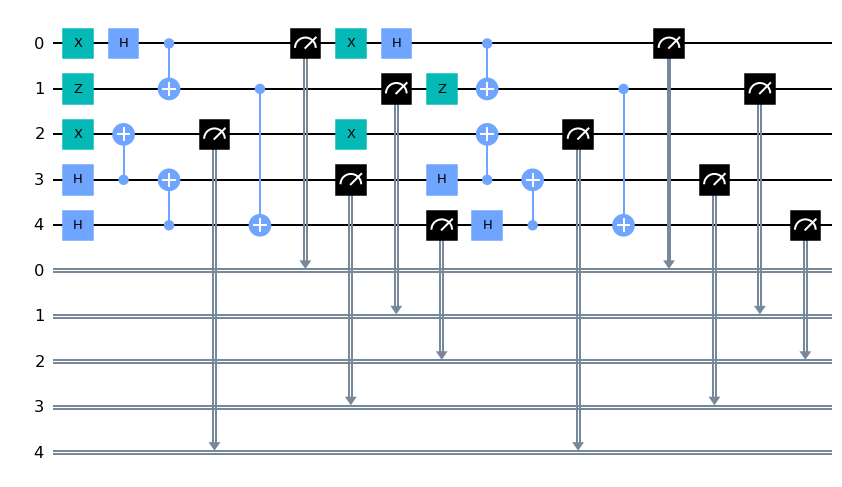

In [13]:
circ_object.circuit.draw(output='mpl')